# Web Scraping Plus Linguistic Analysis

**Overview**

- Identify and explore the data source.
- Use browser developer tools to inspect and understand the website structure.
- Manipulate URL query parameters to efficiently access data.
- Prepare to automate the collection of links and content.
- Scrape chosen data in a structured way.
- Analyze the data and present the results.


## 1. Identifying the Data Source

Suppose you want to gather presidential speeches, debates, and related documents from specific years. [The American Presidency Project](https://www.presidency.ucsb.edu) is a suitable source.

- Visit the website. Look around to find out if it will be of any use.
- Notice the search function in the top right corner and click it.

<img src="https://github.com/current-meantime/webscraping-simplified/blob/main/screenshots/main_page.png?raw=true"/>



### Find out where the specific data that you want is
- Use the search option to filter results **by date**. Let's set the dates to cover the year 2024.
- After submitting the search, a list of links to relevant documents appears. Check them out.
- You have probably learnt that <font color='green'>the links contain the texts</font> that we'll want to scrape.
- For now, keep in mind that we'll somehow have to <font color='green'>obtain a list containing the links</font> in order to <font color='green'>visit them one by one automatically</font> and <font color='green'>extract the texts from the pages they point to.</font>

<img src="https://github.com/current-meantime/webscraping-simplified/blob/main/screenshots/search_page.png?raw=true"/>

## 2. Exploring with Developer Tools

To understand how the website loads and displays data:

- Press `F12` to open Developer Tools.
- Go to the **Network** tab, then select **Fetch/XHR** (or experiment with other tabs).
- Reload the page (`Ctrl+R`) and scroll down to load more results.
- Inspect the network requests to see if the responses contain the document links, ideally in a format such as JSON.

If the links are not present in the network responses, switch to inspecting the HTML structure:

- Use the **Select Element** tool (top left in Dev Tools or `Ctrl+Shift+C`).
- Hover over a document link to locate its HTML element.
- Note the structure - typically, all result links are nested similarly.
- Observe that the links are partial (e.g., `documents/exchange-with-reporters-chappaqua-new-york`). You’ll need to combine these with the base URL in the scraping script.

<img src="https://github.com/current-meantime/webscraping-simplified/blob/main/screenshots/link_element.png?raw=true"/>


## 3. Manipulating Query Parameters

When you perform a search, the URL changes from
```
https://www.presidency.ucsb.edu/advanced-search
```

to something like:

```
https://www.presidency.ucsb.edu/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D=01-01-2024&to%5Bdate%5D=12-31-2024&&items_per_page=25
```

After the `?`, query params were added. *(You can see this at the top of the second image in the address bar)*


### Experimenting with date params
Notice the dates in the url. **Change these parts in the address bar.**
* What happens when you change the starting date year to `2003` and the ending date year to `2004`?
* What happens when you change the starting year to `2026` and the ending year to `2028`?
* What happens when you change the starting year to `2023` and the ending year to `2021`?

### Experimenting with `items_per_page` param
Notice what's at the end of this url - the `items_per_page` param. It would be useful for us to **display as many items on the page as possible** - that way, we won't have to go through more pages than needed to get all links from the desired time periods. Let's see what we can do about it.
* What happens when we change the number to `50`?
* What happens when we change the number to `0`?
* Since we would like a possibly large number, let's try `500` now. What happens?
* What happens when we change the number to `100`? (the maximum that's available normally when you click the blue '#per page' field)

#### Conclusions
As you can see from both the `dates` and the `items_per_page` example, some changes yield results, some not, and some throw errors. Either way, it's good to look around like that to know what possibilities there are. Now we know that the max `items_per_page` we can get is `100`. We'll use that in the script.

### Going through the results pages
But how we'll we go though the pages displaying the links **automatically**? Let's investigate the page a bit more. Click the next button at the bottom of the page.

Check out the url - it has changed again. There's a new param and value now: `page=1`.

<img src="https://github.com/current-meantime/webscraping-simplified/blob/main/screenshots/next_page.png?raw=true"/>
We can see the page param in the adress bar.


#### Experimenting with the pages param
* What happens when we change the number to `5`?
* What happens when we change the number to `1000`?
* What happens when we change the number to `0`?

#### Conclusion
Now we know that:
* the first page of result has the param value of `0` (`page=0`),
* we can visit a certain page by changing the param value, for example page 5 by changing the value to 5,
* and that, in this case, the value 1000 is too high because there aren't that many pages.

### Sum-up
- **Dates:** Change the `from[date]` and `to[date]` parameters in the URL to adjust the time range.
- **Items per page:** Increase `items_per_page` to display more results per page (e.g., 100 is the maximum allowed).
- **Pagination:** After the first page, a `page` parameter appears (e.g., `page=1`). Adjust this to navigate through result pages and bear in mind that you can access the first page through `page=0`, even though this param doesn't automatically appear in the adress bar - reconnaissance is key.

## 4. Planning the Scraping Script

**Steps:**

1. Set the params. How many pages do we need to go thorugh to get all the results? Identify the number of results and calculate the number of pages: divide the total number of results by 100 (max per page) and round up.
2. For each page, construct the URL with the correct query parameters.
3. For each result page, extract the partial links to the documents.
4. Combine partial links with the base URL.
5. Visit each document link and extract the main content.

## 5. Writing the script

### Imports
First, let's import everything we need.

- `ceil` function from the `math` module to round up division results
- `requests` library for downloading web page content
- `BeautifulSoup` class for parsing HTML and extracting data
- `urljoin` for joining URL elements
- `sleep` function from the `time` module to control scraping speed and avoid spamming the website

In [2]:
from math import ceil
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from time import sleep

### Declaring base variables
We'll need to manipulate the url and the params inside it - let's prepare for that.


In [3]:
# query parameters

year_to_scrape = 2020  # the year to search - you can change this
start_date = f"01-01-{year_to_scrape}"
end_date = f"12-31-{year_to_scrape}"

# the site displays a maximum of 100 results per page, so we set it to 100
# the more results per page, the fewer pages to process
items_per_page = 100

starting_page = "page=0"

print(f"\nINFO: year_to_scrape is set to {year_to_scrape}.\nINFO: starting_page is set to {starting_page}.\nINFO: items_per_page is set to {items_per_page}.")


INFO: year_to_scrape is set to 2020.
INFO: starting_page is set to page=0.
INFO: items_per_page is set to 100.


### Declare the url

In [4]:
base_url = "https://www.presidency.ucsb.edu"
extended_url_part = f"/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D={start_date}&to%5Bdate%5D={end_date}&person2=&items_per_page={items_per_page}&{starting_page}"
first_page_url = urljoin(base_url, extended_url_part) # use urljoin to combine all of the url parts
print(f"\nINFO: first_page_url is set to {first_page_url}.")


INFO: first_page_url is set to https://www.presidency.ucsb.edu/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D=01-01-2020&to%5Bdate%5D=12-31-2020&person2=&items_per_page=100&page=0.


### See if the page responds and get its raw HTML content
- `requests` is a library for sending HTTP requests
- `requests.get` sends a GET request to the given URL
- `.text` returns the response as text
- what is stored in the `response` variable is raw HTML

In [5]:
response = requests.get(first_page_url).text
response

'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML+RDFa 1.0//EN"\n  "http://www.w3.org/MarkUp/DTD/xhtml-rdfa-1.dtd">\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/ dc: http://purl.org/dc/terms/ foaf: http://xmlns.com/foaf/0.1/ og: http://ogp.me/ns# rdfs: http://www.w3.org/2000/01/rdf-schema# sioc: http://rdfs.org/sioc/ns# sioct: http://rdfs.org/sioc/types# skos: http://www.w3.org/2004/02/skos/core# xsd: http://www.w3.org/2001/XMLSchema#">\n<head profile="http://www.w3.org/1999/xhtml/vocab">\n  <meta charset="utf-8"><script type="text/javascript">(window.NREUM||(NREUM={})).init={ajax:{deny_list:["bam.nr-data.net"]}};(window.NREUM||(NREUM={})).loader_config={licenseKey:"dee899de70",applicationID:"80106271"};;/*! For license information please see nr-loader-rum-1.292.0.min.js.LICENSE.txt */\n(()=>{var e,t,r={122:(e,t,r)=>{"use strict";r.d(t,{a:()=>i});var n=r(944);function i(e,t){try{if(!e||"object"!=typeof e)return(0,n.R)(3);if(!t||"object"!=typeof t)return(0

### Parse the HTML using BeautifulSoup
- `soup` is the BeautifulSoup object containing the parsed HTML
- `"html.parser"` specifies the parser to use



In [6]:
soup = BeautifulSoup(response, "html.parser")

### Find out the total number of search results and pages
We'll use this number to calculate the number of pages we'll have to iterate through.

Because we inspected the page structure with Dev Tools, we know that the number of results is clearly stated in a `div` with a CSS class `view-header`, which contains text following the pattern "{num_of_presented_results} of {number_of_all_results}". Therefore, we need to find that element and get the number that is after "of".
- `div` is the HTML element containing the header, so that's what we want to select
- `view-header` is the CSS class identifying the header element
- `.find` locates the first element matching the selector
- `.get_text` returns the text inside the element
- `.index` returns the index of the first occurrence of the element
- it's important to use `class_` not `class` because `class` is Python's reserved keyword

In [7]:
header = soup.find("div", class_="view-header")
if header:
    text = header.get_text()
    parts = text.strip().split()
    if "of" in parts:  # we expect something like "1-100 of 1234" in the header
        try:
            total_results = int(parts[parts.index("of") + 1])
        except ValueError as e:
            print(e)
total_results

5184

We know that there can be max 100 results per page and that there are overall as many results as it is stored in the `total_results` variable. We can therefore calculate the number of pages to iterate through.

In [8]:
pages_count = ceil(total_results / items_per_page)
pages_count

52

### Generate urls of pages containing the search results (aka the links that contain the texts that we want to scrape)


In [9]:
pages_with_links = []
for page_num in range(pages_count):
      page_with_links = (
          f"https://www.presidency.ucsb.edu/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D={start_date}&to%5Bdate%5D={end_date}&person2=&items_per_page={items_per_page}&page={page_num}"
      )
      pages_with_links.append(page_with_links)
pages_with_links[:3] # check the first few links

['https://www.presidency.ucsb.edu/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D=01-01-2020&to%5Bdate%5D=12-31-2020&person2=&items_per_page=100&page=0',
 'https://www.presidency.ucsb.edu/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D=01-01-2020&to%5Bdate%5D=12-31-2020&person2=&items_per_page=100&page=1',
 'https://www.presidency.ucsb.edu/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D=01-01-2020&to%5Bdate%5D=12-31-2020&person2=&items_per_page=100&page=2']

### Fetching the actual links to texts
We'll able to do this because we investigated the page structure with DevTools. We know, for example that the `td` HTML elements contain partial links that we'll need to combine with the base url.

In [10]:
links_to_texts = []
for td in soup.select("td.views-field.views-field-title a"):
  href = td.get("href", "")
  if href.startswith("/documents/"):
      links_to_texts.append(urljoin(base_url, href))
links_to_texts[:3] # check the first few links

['https://www.presidency.ucsb.edu/documents/pool-reports-january-1-2020',
 'https://www.presidency.ucsb.edu/documents/message-national-stalking-awareness-month-0',
 'https://www.presidency.ucsb.edu/documents/message-national-biotechnology-month']

### Scraping the texts


> **For the presentation purposes we'll only go through the first page.** You can, however, add one more loop to go through the number of pages that we stored in the `pages_count` variable - remember to dynamically create proper urls with the `pages=` param updated with each iteration.


1. Visit one of the links and investigate the HTML document structure with  DevTools.
2. Notice that the texts are contained within a `div` with a `field-docs-content` class.
3. Extract and store the texts.

In [15]:
scraped_content = {}
for link in links_to_texts:
        try:
            response = requests.get(link).text
            soup = BeautifulSoup(response, "html.parser")

            # extract the text from the 'div' element
            speech_div = soup.find("div", class_="field-docs-content")
            speech_text = speech_div.get_text(separator=" ", strip=True) if speech_div else ""

            # get the title from the link
            title = link.split("/")[-1]

            scraped_content[title] = speech_text

            sleep(0.6)  # use the sleep function in order not to spam the website with requests

        except Exception as e:
            print(f"Error occured. Error: {e}")


In [22]:
len(scraped_content) # check if anything's missing

100

In [23]:
for val in scraped_content.values():
  print(val) # see if the texts actually got scraped
  break

Pool Reports by Catherine Lucey , The Wall Street Journal Sent: Reports: January 1, 2020 9:51 Out of Town Pool Report #1 - Mar-a-Lago Departure Good morning and Happy New Year! It is a sunny 66 degrees in Palm Beach. The presidential motorcade departed Mar-a-Lago at 9:49 AM for an undisclosed location. The pool has not seen POTUS today. January 1, 2020 10:01 Out of Town Pool Report #2 - Arrival at Trump International The president's motorcade arrived at Trump International Golf Club in West Palm Beach at 9:57 AM. The pool is now holding in the parking lot of the library across the street. Your pooler has asked for details on the president's activities today and will pass along any information. January 1, 2020 [ APP Note: Report #3 does not exist or was not received by the APP. ] January 1, 2020 15:52 Out of Town Pool Report #4 - Arrival at Mar-a-Lago The president's motorcade arrived back at Mar-a-Lago at 3:41 PM. We have not received any additional information about the president's ac

In [43]:
texts = ''.join(scraped_content.values()) # join all the texts into one string for easier analysis
texts[3000:3400]

'aging, or liking and commenting on social media posts. It is vital that online behavior be held to the same standards of respect and integrity as are our interactions in person. Stalking behavior is a manipulative tool used to exert control and incite fear, and victims can often feel isolated and vulnerable. If you or someone you know is experiencing this abuse, there are many resources available '

# Analysis Through Visualization

Make sure to download all the neccessary components of `nltk`.

In [35]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [46]:
from collections import Counter
from string import punctuation # for text cleanup

In [47]:
texts = ''.join([c for c in texts.lower() if c=="'" or c not in punctuation])
tokenized = nltk.word_tokenize(texts) # tokenize the text

In [48]:
tagged = nltk.pos_tag(tokenized) # pos tag the text

In [50]:
tags = [tup[1] for tup in tagged] # get tags only
len(tags)

95628

In [70]:
tags_count = Counter(tags) # count the number of occurences of each tag

In [56]:
nltk.download('tagsets_json')
nltk.help.upenn_tagset() # see what the tags mean

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets_json.zip.


In [71]:
tags_count = tags_count.most_common()
tags_count

[('NN', 20106),
 ('IN', 10302),
 ('JJ', 8872),
 ('DT', 7581),
 ('NNS', 7021),
 ('PRP', 4567),
 ('VB', 4476),
 ('RB', 4082),
 ('CC', 3985),
 ('VBP', 3778),
 ('TO', 2728),
 ('VBD', 2679),
 ('CD', 2598),
 ('VBZ', 2423),
 ('VBG', 2245),
 ('VBN', 1773),
 ('PRP$', 1484),
 ('MD', 1379),
 ('WDT', 510),
 ('POS', 506),
 ('WP', 500),
 ('JJR', 388),
 ('WRB', 383),
 ('RP', 351),
 ('NNP', 209),
 ('JJS', 203),
 ('RBR', 179),
 ('EX', 116),
 ('RBS', 74),
 ('FW', 41),
 ('PDT', 38),
 ('UH', 14),
 ('NNPS', 13),
 ("''", 11),
 ('$', 8),
 ('WP$', 5)]

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [73]:
# convert to pandas dataframe for easier data manipulation
df = pd.DataFrame(tags_count, columns=['POS', 'Count'])
df.sort_values(by='Count', ascending=False, inplace=True)

### POS Tag Frequency Bar Plot

/tmp/ipython-input-74-2399547981.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='POS', y='Count', palette='viridis')


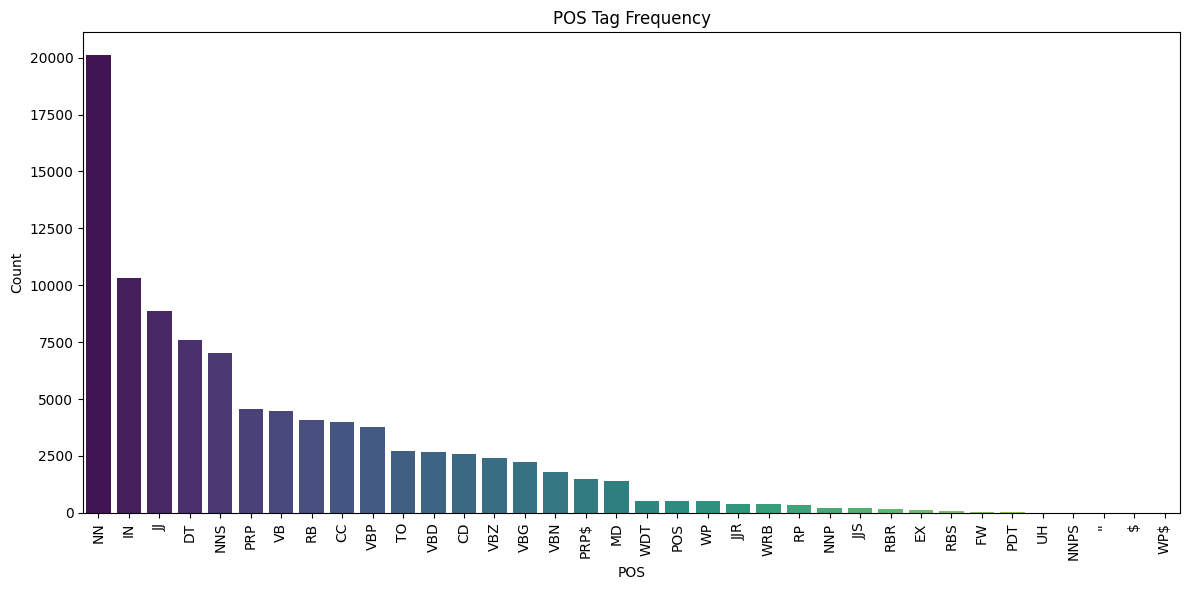

In [74]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='POS', y='Count', palette='viridis')
plt.title('POS Tag Frequency')
plt.xticks(rotation=90)
plt.tight_layout()

### Lexical vs. Grammatical POS Tags

/tmp/ipython-input-84-3968055313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Category', y='Count', palette='pastel')


Text(0.5, 1.0, 'Lexical vs. Grammatical POS Tags')

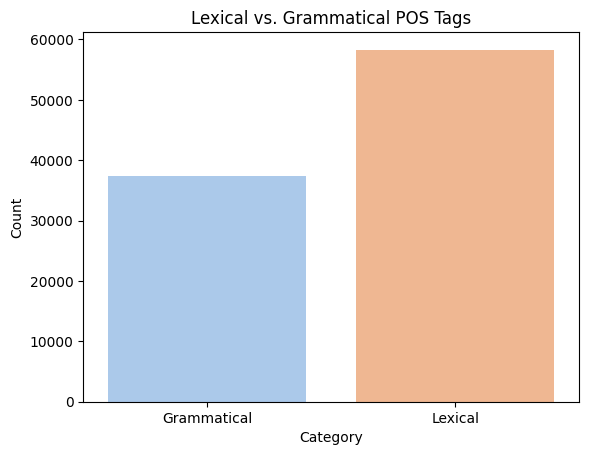

In [84]:
lexical = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
df['Category'] = df['POS'].apply(lambda x: 'Lexical' if x in lexical else 'Grammatical')
summary = df.groupby('Category')['Count'].sum().reset_index()

sns.barplot(data=summary, x='Category', y='Count', palette='pastel')
plt.title('Lexical vs. Grammatical POS Tags')

### Verb Forms Frequency

/tmp/ipython-input-86-2353593988.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=verbs, x='POS', y='Count', palette='mako')


Text(0.5, 1.0, 'Verb Forms Frequency')

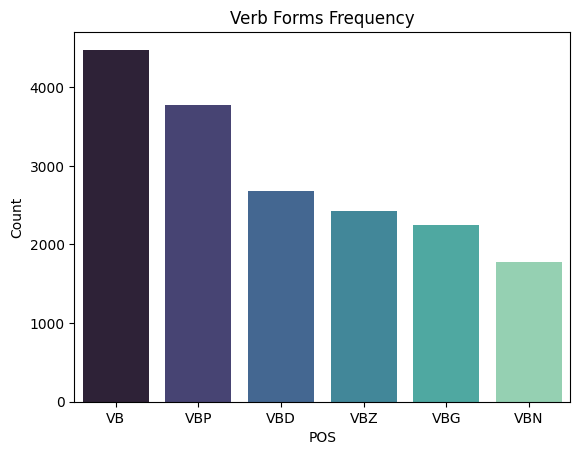

In [86]:
verbs = df[df['POS'].str.startswith('VB')]
sns.barplot(data=verbs, x='POS', y='Count', palette='mako')
plt.title('Verb Forms Frequency')

### Noun Types Frequency

/tmp/ipython-input-88-2505589178.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nouns, x='POS', y='Count', palette='crest')


Text(0.5, 1.0, 'Noun Types Frequency')

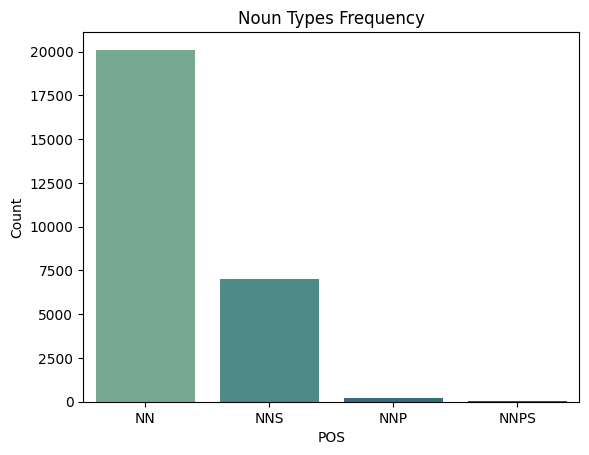

In [88]:
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
nouns = df[df['POS'].isin(noun_tags)]
sns.barplot(data=nouns, x='POS', y='Count', palette='crest')
plt.title('Noun Types Frequency')

### Adjective & Adverb Comparison

/tmp/ipython-input-89-3531951010.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=adj_adv, x='POS', y='Count', palette='rocket')


Text(0.5, 1.0, 'Adjective & Adverb Comparison')

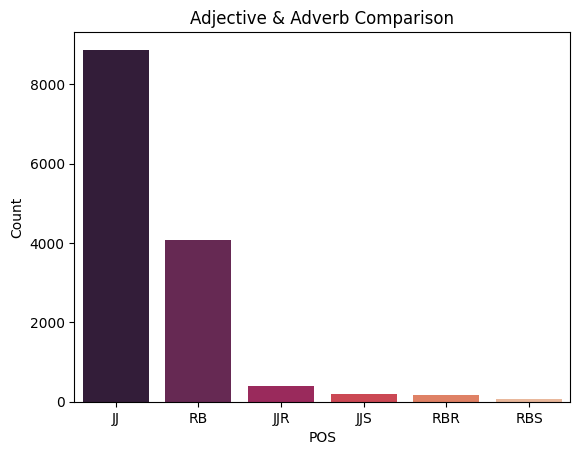

In [89]:
adj_adv_tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
adj_adv = df[df['POS'].isin(adj_adv_tags)]
sns.barplot(data=adj_adv, x='POS', y='Count', palette='rocket')
plt.title('Adjective & Adverb Comparison')

### POS Bigram Co-occurrence Heatmap

Text(0.5, 1.0, 'POS Bigram Co-occurrence Heatmap')

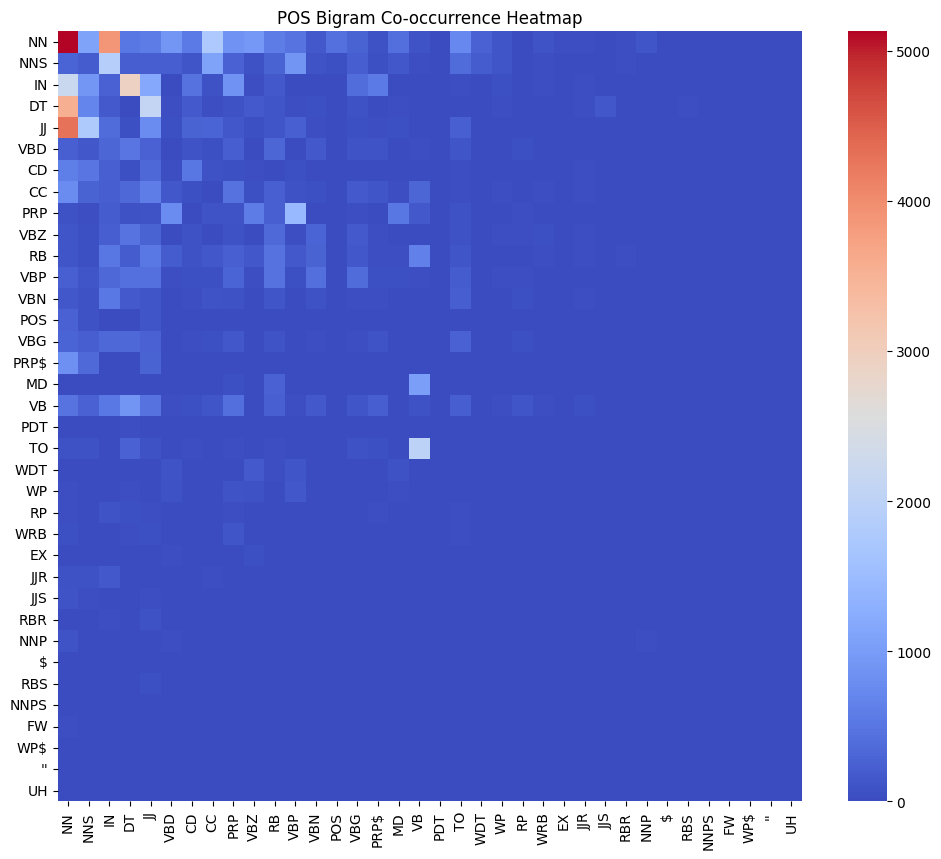

In [102]:
pos_sequence = [pos for (word, pos) in tagged]

# generate bigrams
bigrams = list(zip(pos_sequence, pos_sequence[1:]))
bigram_freq = Counter(bigrams)

# preserve order of 1st appearance
unique_tags = list(dict.fromkeys(pos_sequence))

# create matrix
bigram_matrix = pd.DataFrame(0, index=unique_tags, columns=unique_tags)

# fill matrix with frequencies
for (a, b), freq in bigram_freq.items():
    bigram_matrix.loc[a, b] = freq

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(bigram_matrix, annot=False, cmap='coolwarm')
plt.title('POS Bigram Co-occurrence Heatmap')

### POS Bigram Heatmap Top 10

We're focusing on top 10 tags to reduce visual clutter.

Text(0.5, 1.0, 'POS Bigram Heatmap (Top 10 POS Tags Only)')

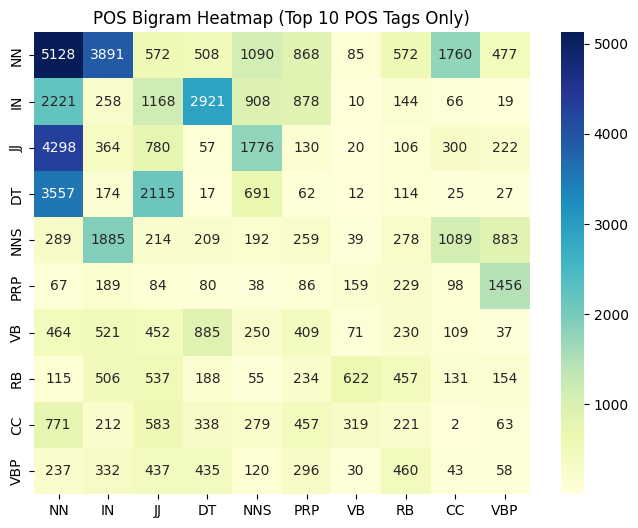

In [98]:
top_tags = [tag for tag, count in Counter(pos_sequence).most_common(10)]

# filter bigram matrix to top tags
filtered_matrix = bigram_matrix.loc[top_tags, top_tags]

plt.figure(figsize=(8, 6))
sns.heatmap(filtered_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('POS Bigram Heatmap (Top 10 POS Tags Only)')

### Normalized Percentages in Heatmap
This converts raw counts to percentages for each row (what percentage of times a given POS is followed by each other POS)

Text(0.5, 1.0, 'Normalized POS Bigram Co-occurrence Heatmap (Row %)')

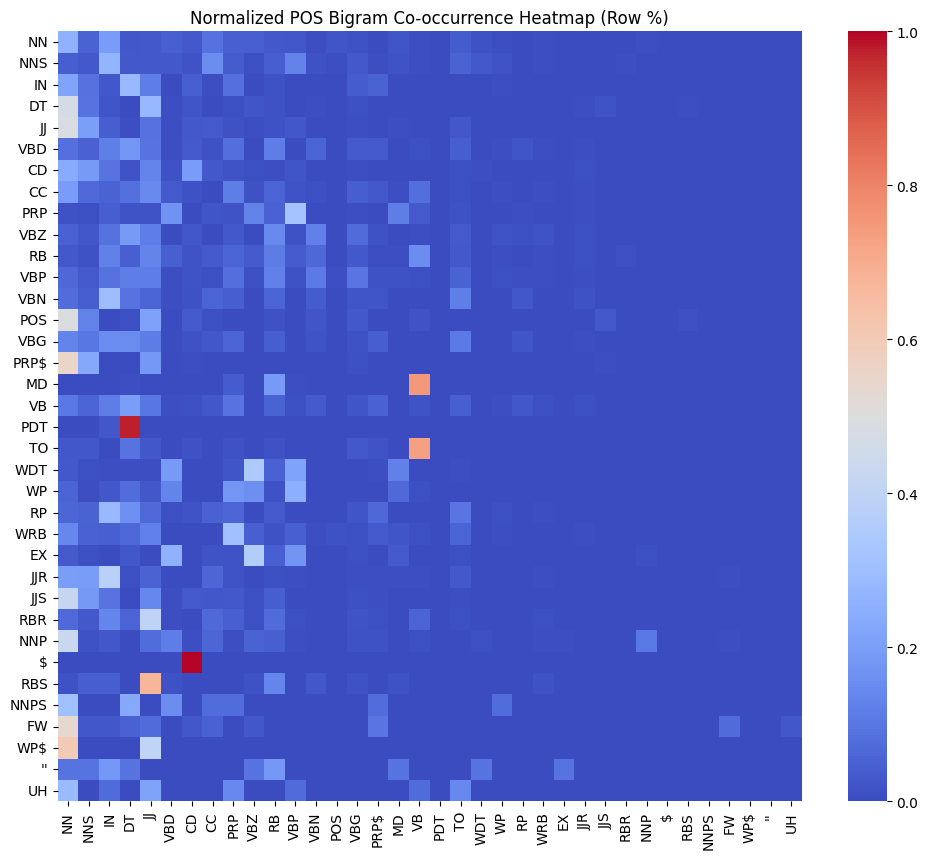

In [103]:
# normalization each row by its total (row-wise percentages)
normalized_matrix = bigram_matrix.div(bigram_matrix.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(normalized_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Normalized POS Bigram Co-occurrence Heatmap (Row %)')

## Top 20 POS Trigrams

Instead of bigrams (pairs), we're now using trigrams (triplets of POS tags):

/tmp/ipython-input-104-2193751204.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trigram_df, x='Count', y=trigram_df['Trigram'].astype(str), palette='flare')


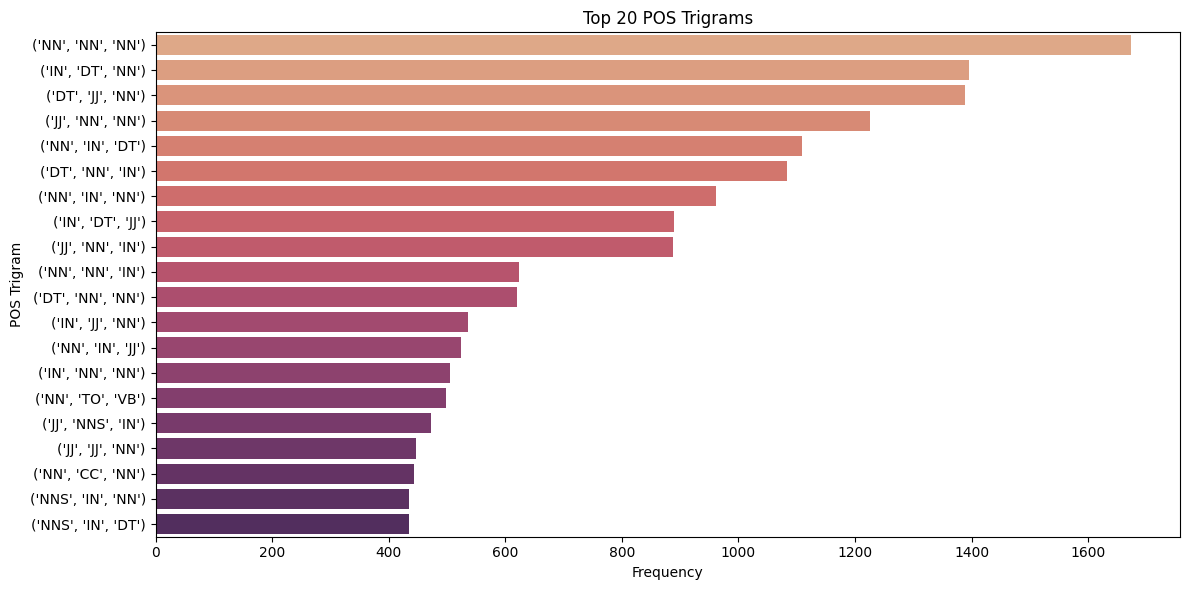

In [104]:
from itertools import islice
# generate trigrams from the sequence
trigrams = list(zip(pos_sequence, islice(pos_sequence, 1, None), islice(pos_sequence, 2, None)))

# set top count to 20
trigram_counts = Counter(trigrams).most_common(20)

# convert to dataframe for display
trigram_df = pd.DataFrame(trigram_counts, columns=['Trigram', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=trigram_df, x='Count', y=trigram_df['Trigram'].astype(str), palette='flare')
plt.title('Top 20 POS Trigrams')
plt.xlabel('Frequency')
plt.ylabel('POS Trigram')
plt.tight_layout()